<a href="https://colab.research.google.com/github/nebyu08/data_sc/blob/main/transfer_learning_for_pnuemonia_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 71 bytes


In [ ]:
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [01:53<00:00, 21.6MB/s]
100% 2.29G/2.29G [01:53<00:00, 21.8MB/s]


In [ ]:
from zipfile import ZipFile
file_name = "/content/chest-xray-pneumonia.zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [ ]:
train="/content/chest_xray/train"
val="/content/chest_xray/val"
test="/content/chest_xray/test"

In [ ]:
!pip install tensorflow_hub first

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# importing the nessary packages

In [ ]:
import tensorflow as tf
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model


from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential

import numpy as np
from glob import glob
import matplotlib.pyplot as plt

import os
import cv2
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# lets use GPU for efficeiency

In [ ]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1


# input in the form of tensors

In [ ]:
#inputing the tensors
train_path="/content/chest_xray/train"
vali_path="/content/chest_xray/val"
test_path="/content/chest_xray/test"

# Define the image size and batch size
image_size = (299, 299)
batch_size = 32

# Load the dataset
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    image_size=image_size,
    batch_size=batch_size,
    class_names = ["NORMAL", "PNEUMONIA"],
    color_mode="rgb"
)
#load a testing dataset
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_path,
    image_size=image_size,
    batch_size=batch_size,
    class_names=["NORMAL","PNEUMONIA"],
    color_mode="rgb"
)
#load the validation dataset
vali_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    vali_path,
    image_size=image_size,
   batch_size=batch_size,
    color_mode="rgb",
    class_names=["NORMAL","PNEUMONIA"]
)
print("training type:",type(train_dataset))
print("testing type:",type(test_dataset))
print("validating type",type(vali_dataset))

Found 5216 files belonging to 2 classes.
Found 624 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
training type: <class 'tensorflow.python.data.ops.batch_op._BatchDataset'>
testing type: <class 'tensorflow.python.data.ops.batch_op._BatchDataset'>
validating type <class 'tensorflow.python.data.ops.batch_op._BatchDataset'>


#cheking the shape of the dataset

In [ ]:
train_size = train_dataset.cardinality().numpy()
print("Training Dataset size:", train_size)

test_size=test_dataset.cardinality().numpy()
print("Testing Dataset size:",test_size)

vali_size=vali_dataset.cardinality().numpy()
print("The Testing Dataset size:",vali_size)

#the result seems off because they are in batches

Training Dataset size: 163
Testing Dataset size: 20
The Testing Dataset size: 1


In [ ]:
#lets check some elements:
image_shape = train_dataset.element_spec[0].shape
print("Image shape:", image_shape)


Image shape: (None, 299, 299, 3)


#display the first few images from our training sets


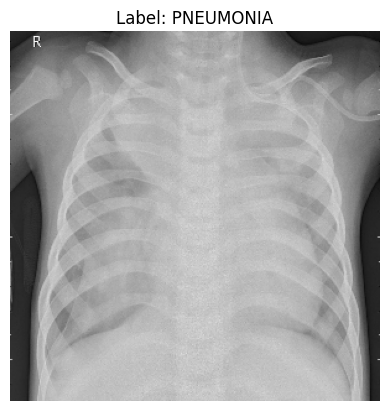

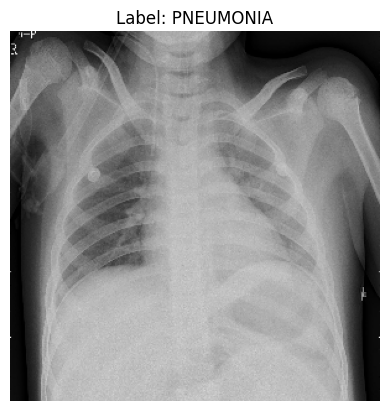

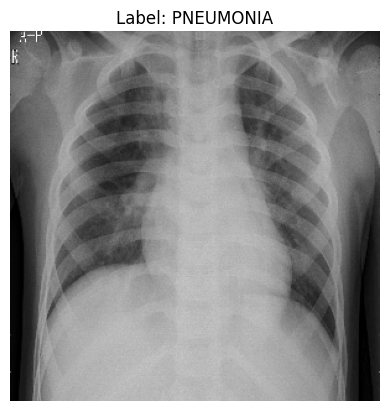

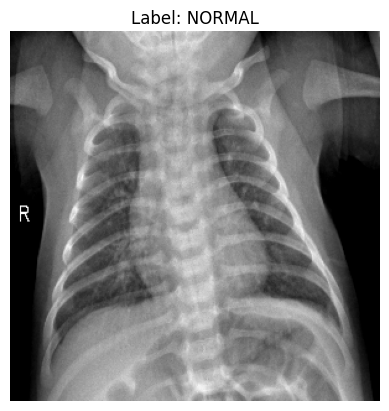

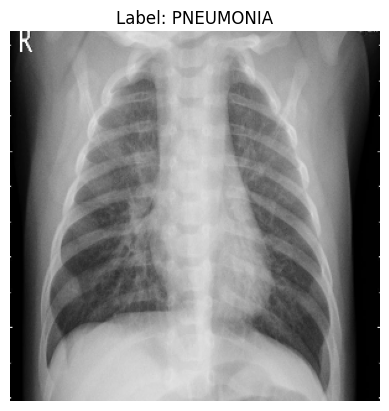

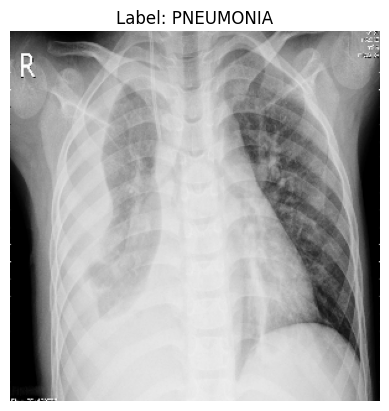

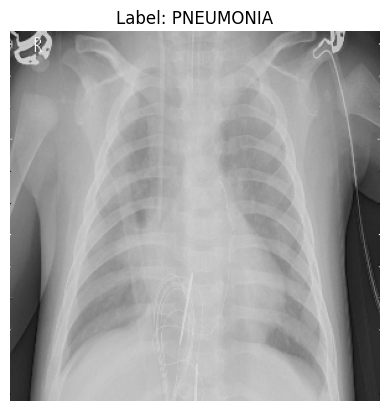

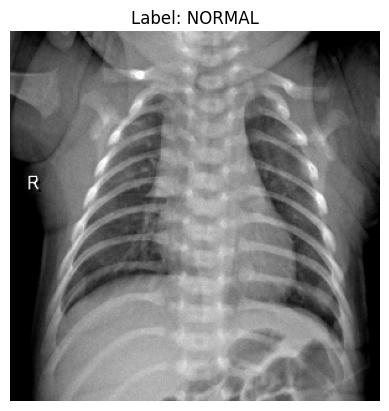

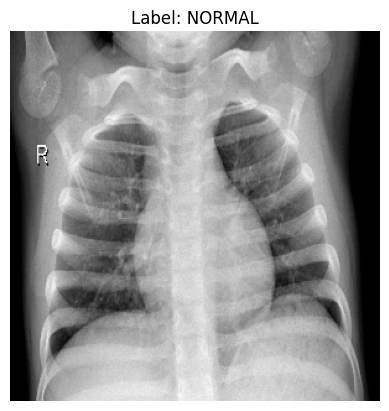

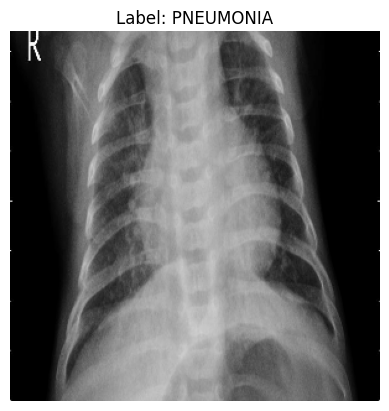

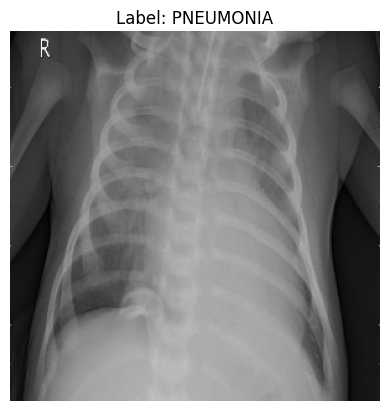

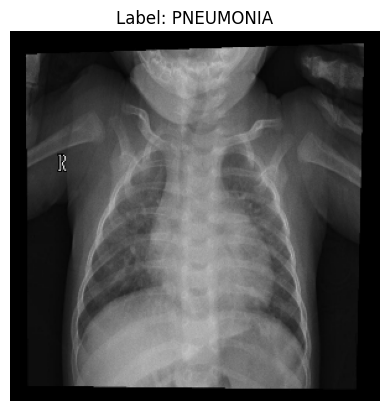

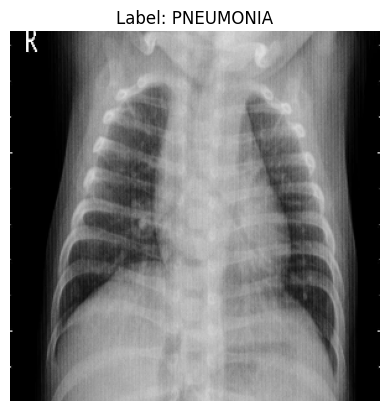

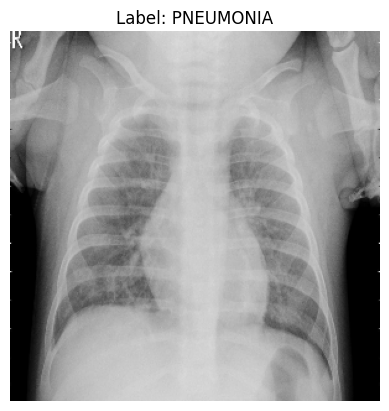

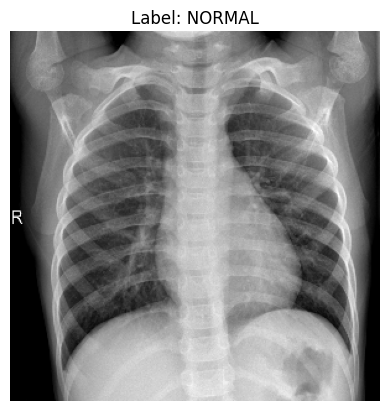

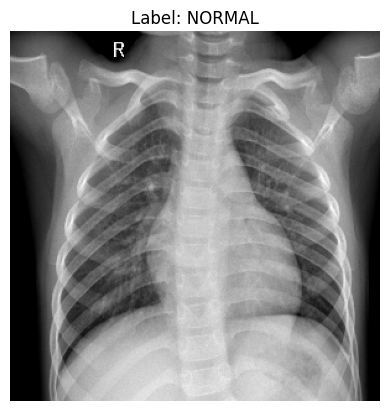

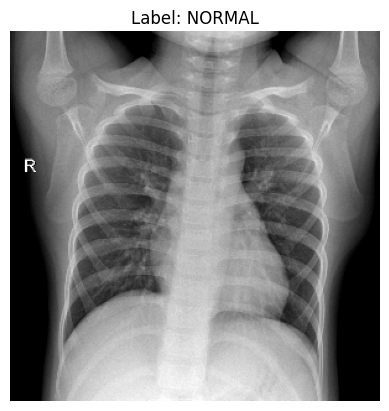

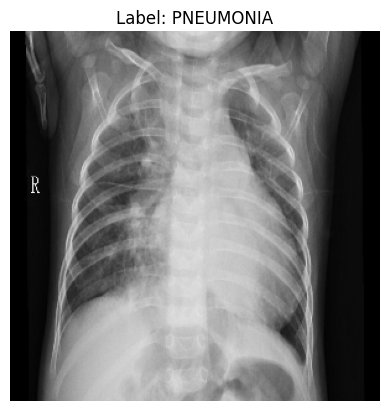

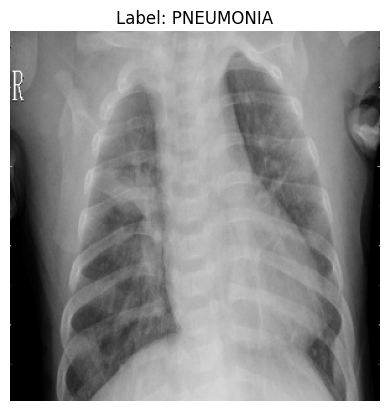

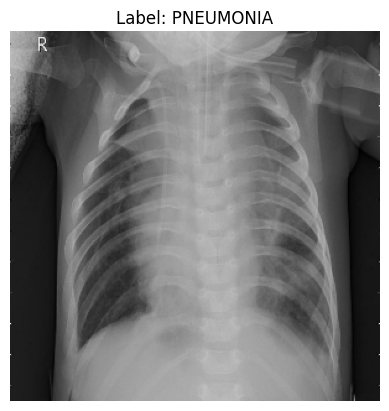

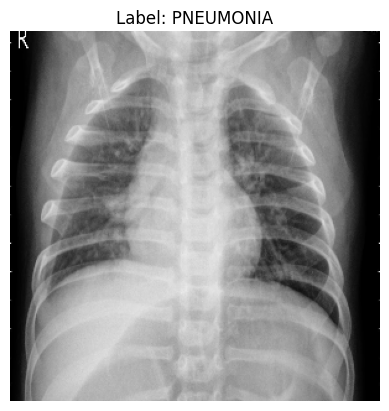

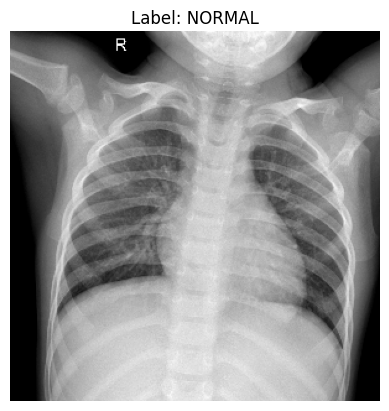

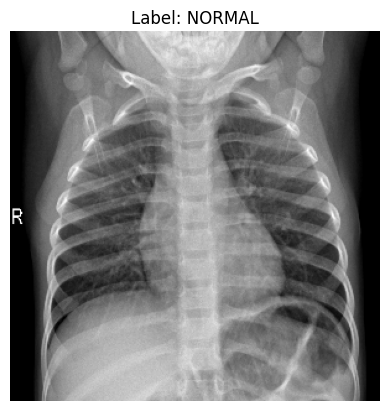

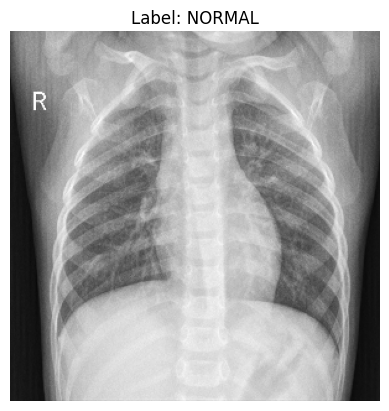

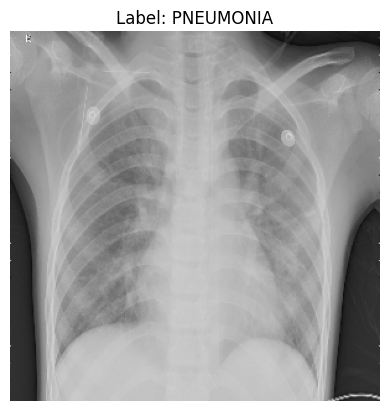

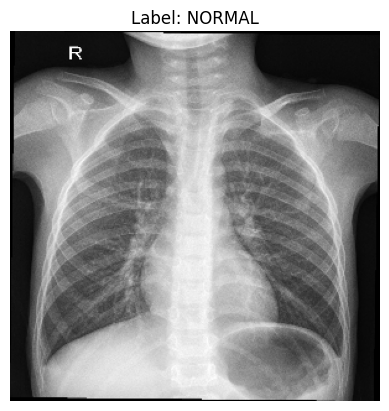

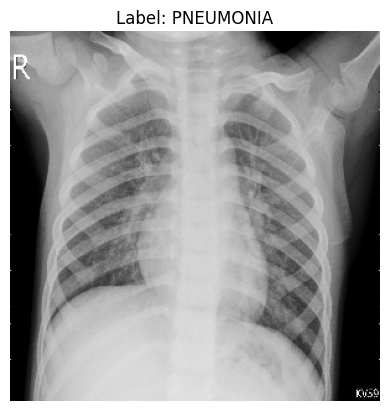

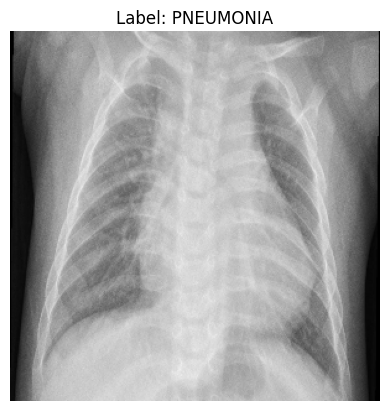

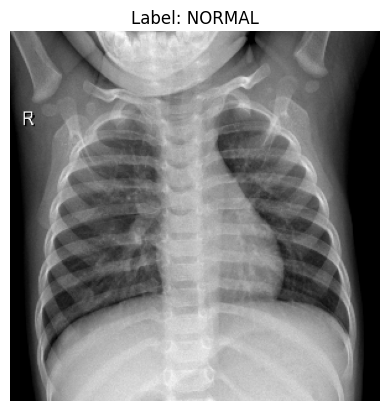

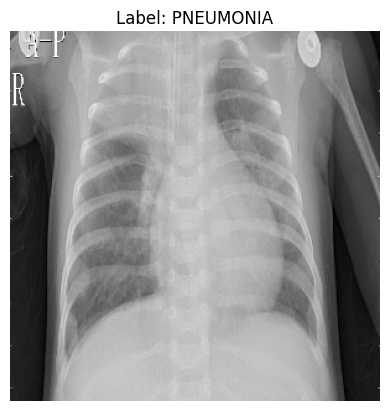

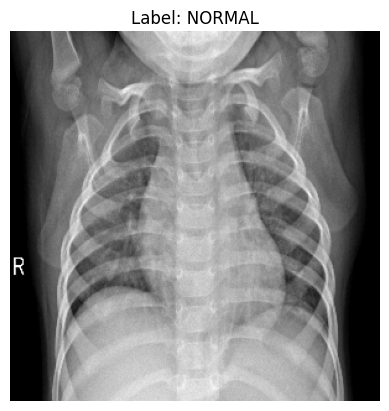

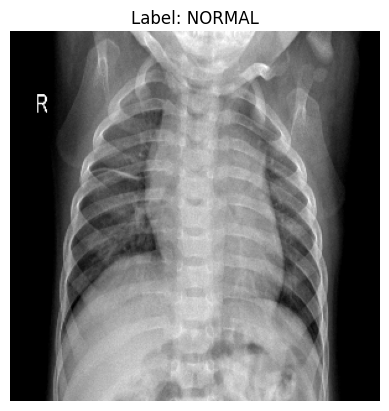

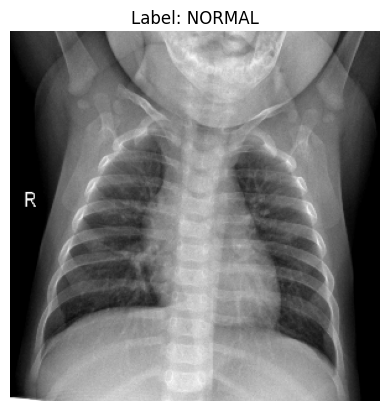

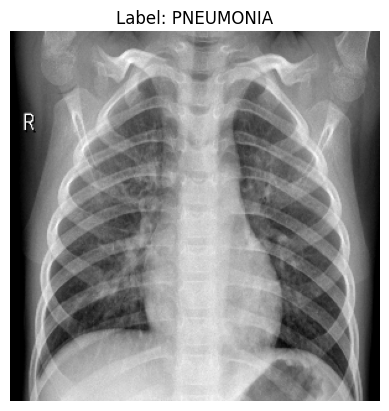

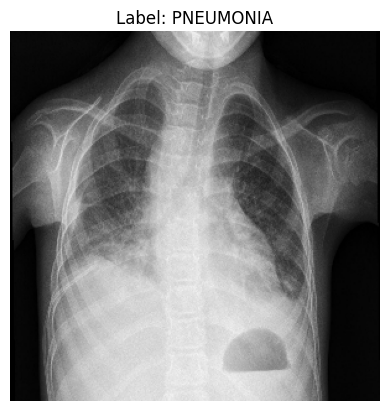

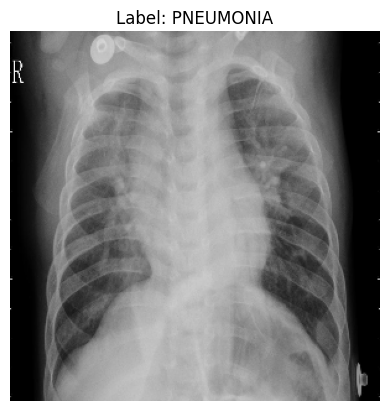

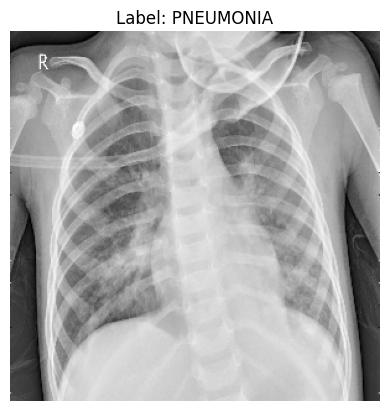

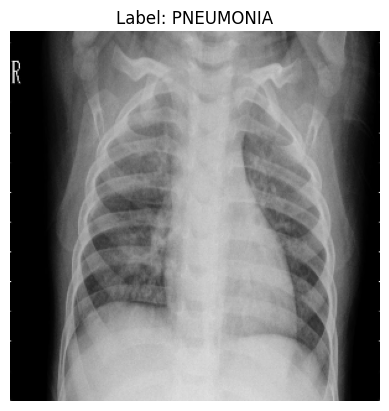

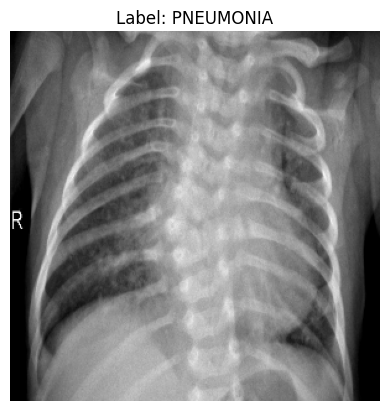

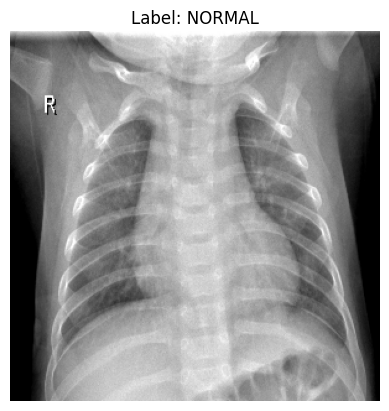

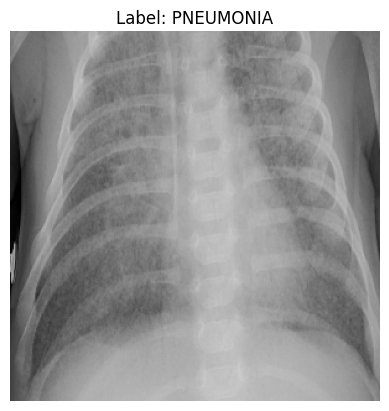

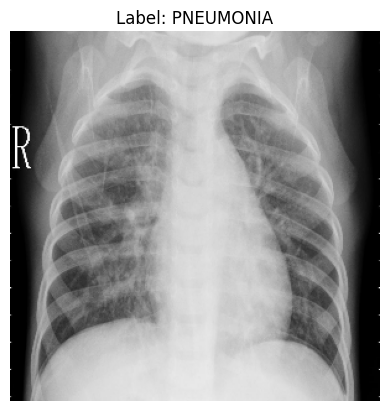

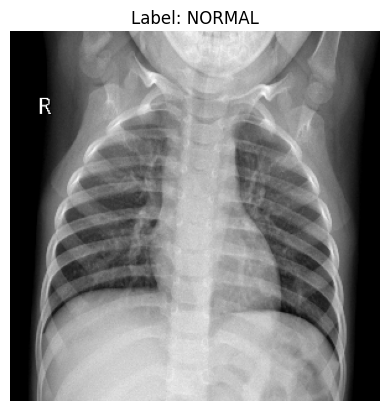

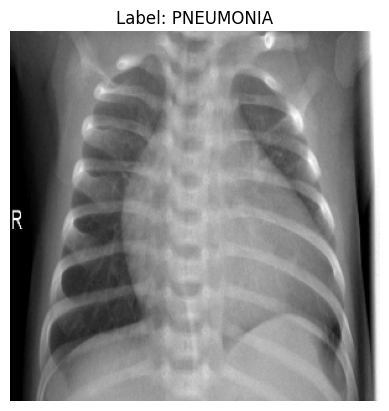

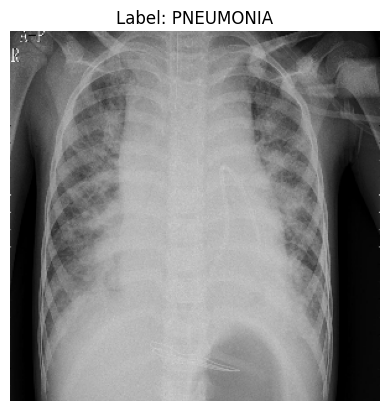

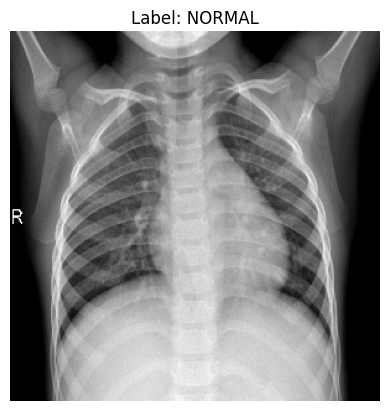

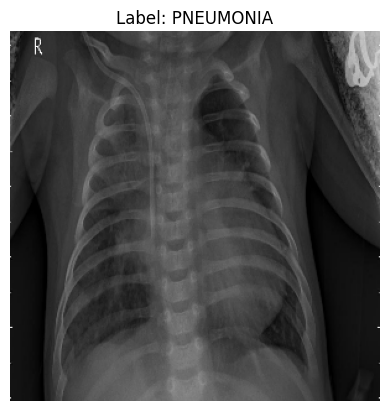

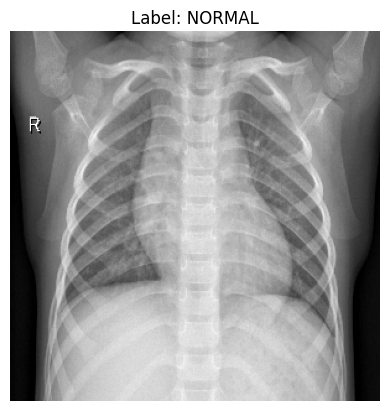

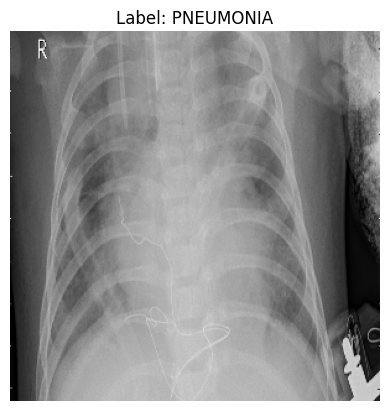

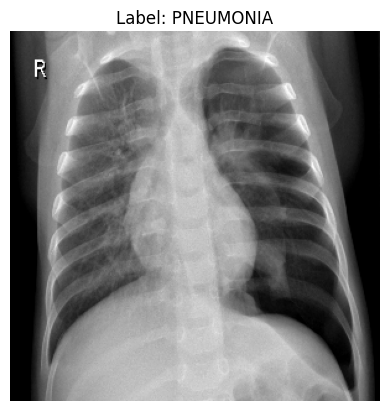

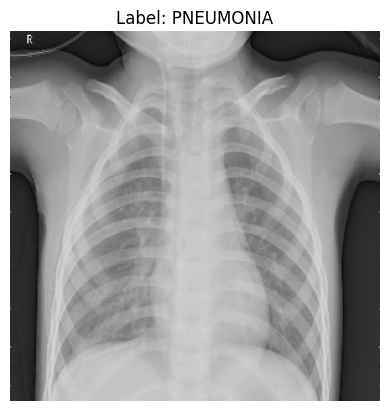

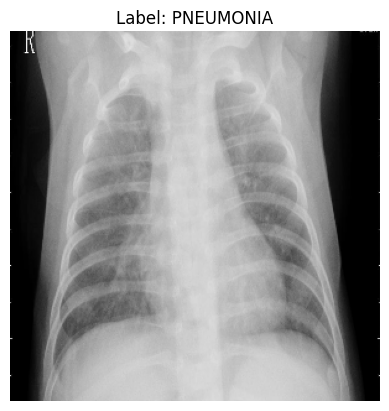

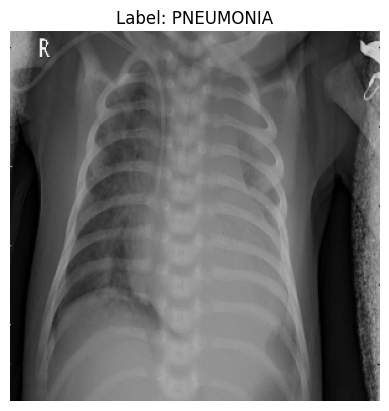

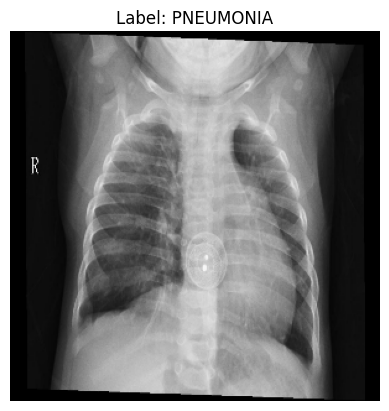

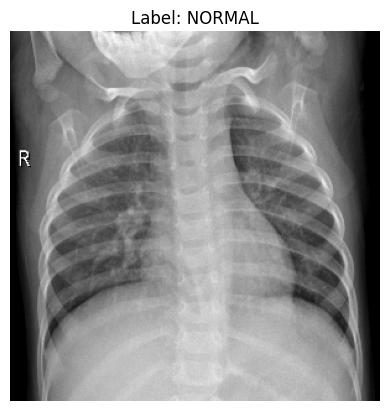

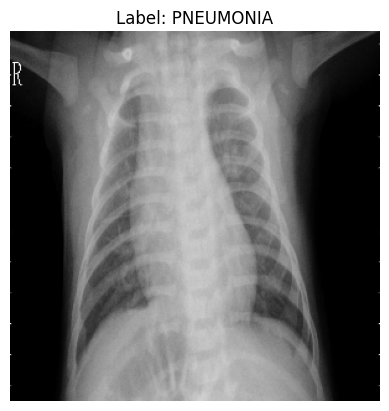

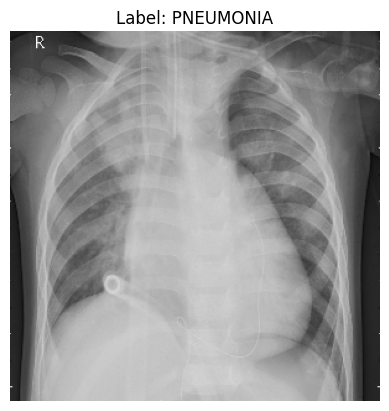

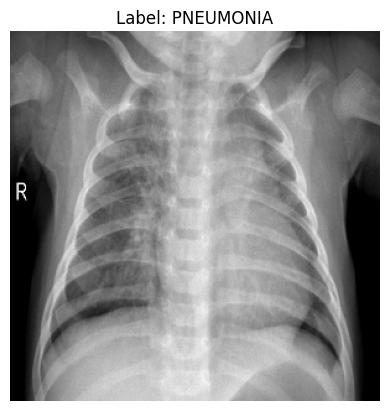

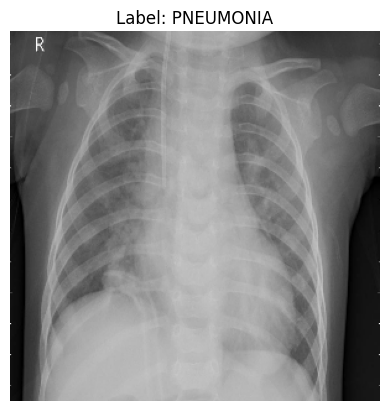

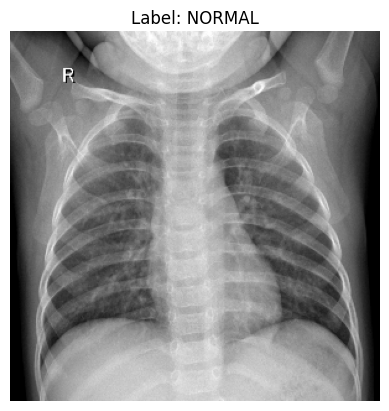

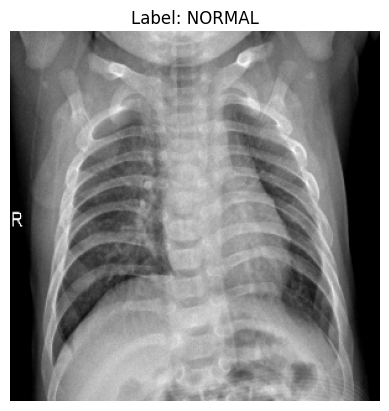

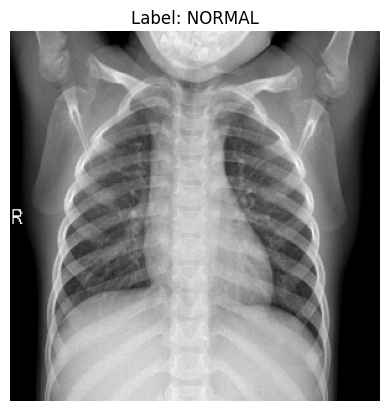

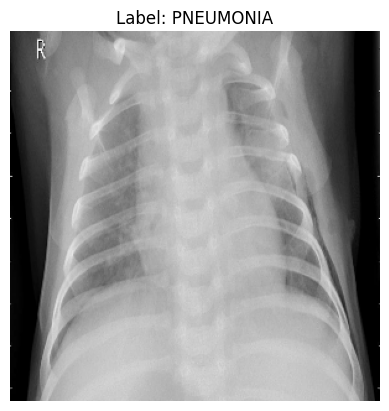

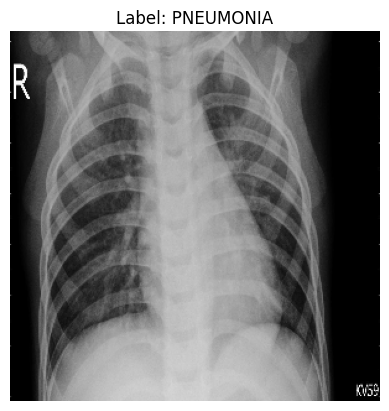

In [ ]:
# Get the first 5 images from the dataset
first_5_images_dataset = train_dataset.take(2)
class_names = ["NORMAL", "PNEUMONIA"]

# Iterate over the dataset and display the images
for image, label in first_5_images_dataset:
    for i in range(len(image)):
        plt.imshow(image[i].numpy().astype("uint8"))
        plt.title("Label: {}".format(class_names[label[i]]))
        plt.axis("off")
        plt.show()


# the data augmentation part

In [ ]:

from tensorflow import keras
from tensorflow.keras import layers

data_augmentation=keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1)
    ]
)


# lets use the xception alread trained model from keras-tensorflow!!!

In [ ]:
base_model=keras.applications.Xception(
    weights = "imagenet",   #we are loading the weights
    input_shape=(299,299,3),   #the image should be 150 pixel by 150 pixel and should be colored
    include_top=False #dont include the last layer of the already trained model
)

83683744/83683744 [==============================] - 5s 0us/step


In [ ]:
#we are freezing the base model
base_model.trainable=False

In [ ]:
#create new model on top
inputs=keras.Input(shape=(299,299,3))    #lets try using 299*299
x=data_augmentation(inputs)

# lets use fine tune the Xception model

In [ ]:
norm_layer=keras.layers.experimental.preprocessing.Normalization()
rescale_layer = keras.layers.experimental.preprocessing.Rescaling(scale=1./127.5, offset=-1)
x = rescale_layer(x)
#define early stopping callbacks
early_stopping = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

# Prepare the datasets with data augmentation
train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y))

#the model needs to be in inference mode
x=base_model(x,training=False)
x=keras.layers.GlobalAveragePooling2D()(x)
x=keras.layers.Dropout(0.2)(x)

outputs=keras.layers.Dense(1)(x)
model=keras.Model(inputs,outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 299, 299, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 299, 299, 3)       0         
                                                                 
 xception (Functional)       (None, 10, 10, 2048)      20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                             

In [ ]:
model.compile(
      optimizer=keras.optimizers.Adam(1e-5),
      loss=keras.losses.BinaryCrossentropy(from_logits=True),
      metrics=[keras.metrics.BinaryAccuracy()],
      #callbacks=[early_stopping]
  )

epochs=2

model.fit(train_dataset ,epochs=epochs,validation_data=vali_dataset)


Epoch 1/2
163/163 [==============================] - 124s 667ms/step - loss: 0.7639 - binary_accuracy: 0.2605 - val_loss: 0.7191 - val_binary_accuracy: 0.5000
Epoch 2/2
163/163 [==============================] - 101s 606ms/step - loss: 0.6650 - binary_accuracy: 0.3200 - val_loss: 0.7330 - val_binary_accuracy: 0.4375


# know lets fine tune the base model

In [ ]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True
model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 20
model.fit(train_dataset,
          epochs=epochs,
          validation_data=vali_dataset,
          callbacks=[early_stopping])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 299, 299, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 299, 299, 3)       0         
                                                                 
 xception (Functional)       (None, 10, 10, 2048)      20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                             

In [ ]:
print("the loass of the model is:",model.evaluate(test_dataset)[0])
print("the accuracy of the model is:",model.evaluate(test_dataset)[1]*100,"%")

20/20 [==============================] - 7s 243ms/step - loss: 0.2948 - binary_accuracy: 0.9295
the loass of the model is: 0.2948068678379059
20/20 [==============================] - 6s 246ms/step - loss: 0.2948 - binary_accuracy: 0.9295
the accuracy of the model is: 92.94871687889099 %
